In [ ]:
code_file= 'MI_bench_qsort.c'
flags =  ['-O0', '-O1', '-O2', '-O3', '-Os', '-Ofast', '-Og', '-fno-inline']

In [ ]:
import subprocess

def check_compatible_flags(code_path, flags):
    compatible_flags = []
    non_compatible_flags = []


    for flag in flags:
        compile_command = f"gcc {code_path} {flag} -lm -o output"
        try:
            compile_result = subprocess.run(compile_command, shell=True, capture_output=True, text=True, timeout=10)
            print("result = ", flag + " ---> ", compile_result.stderr)
            if compile_result.returncode == 0:
                compatible_flags.append(flag)
            else:
                error_message = compile_result.stderr

                non_compatible_flags.append(flag)
        except subprocess.TimeoutExpired:
            non_compatible_flags.append(flag)

    return compatible_flags, non_compatible_flags


# Path to the new C file you want to test
new_code_path = code_file  # Change this to the path of your new code

# Check and print compatible and non-compatible flags
compatible_flags, non_compatible_flags = check_compatible_flags(new_code_path, flags)

print("Compatible GCC Flags:")
print(compatible_flags)
print("\nNon-Compatible GCC Flags:")
print(non_compatible_flags)

result =  -O0 --->  
result =  -O1 --->  
result =  -O2 --->  
result =  -O3 --->  
result =  -Os --->  
result =  -Ofast --->  
result =  -Og --->  
result =  -fno-inline --->  
Compatible GCC Flags:
['-O0', '-O1', '-O2', '-O3', '-Os', '-Ofast', '-Og', '-fno-inline']

Non-Compatible GCC Flags:
[]


In [ ]:
pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 27.9 MB/s eta 0:00:00


Episode 1/100, Total Reward: -2.1354139999999995
Episode 2/100, Total Reward: -2.2466000000000004
Episode 3/100, Total Reward: -2.1050989999999987
Episode 4/100, Total Reward: -2.223160000000001
Episode 5/100, Total Reward: -2.038715999999999
Episode 6/100, Total Reward: -2.0174279999999998
Episode 7/100, Total Reward: -1.985380000000001
Episode 8/100, Total Reward: -2.194748
Episode 9/100, Total Reward: -2.329632
Episode 10/100, Total Reward: -2.0654079999999992
Episode 11/100, Total Reward: -1.9333320000000005
Episode 12/100, Total Reward: -2.1978570000000004
Episode 13/100, Total Reward: -2.0801699999999994
Episode 14/100, Total Reward: -2.0219589999999994
Episode 15/100, Total Reward: -1.9357930000000005
Episode 16/100, Total Reward: -2.088277
Episode 17/100, Total Reward: -1.8222179999999992
Episode 18/100, Total Reward: -2.2809129999999995
Episode 19/100, Total Reward: -2.3982830000000006
Episode 20/100, Total Reward: -2.1088529999999994
Episode 21/100, Total Reward: -2.007456999

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Q-table saved.


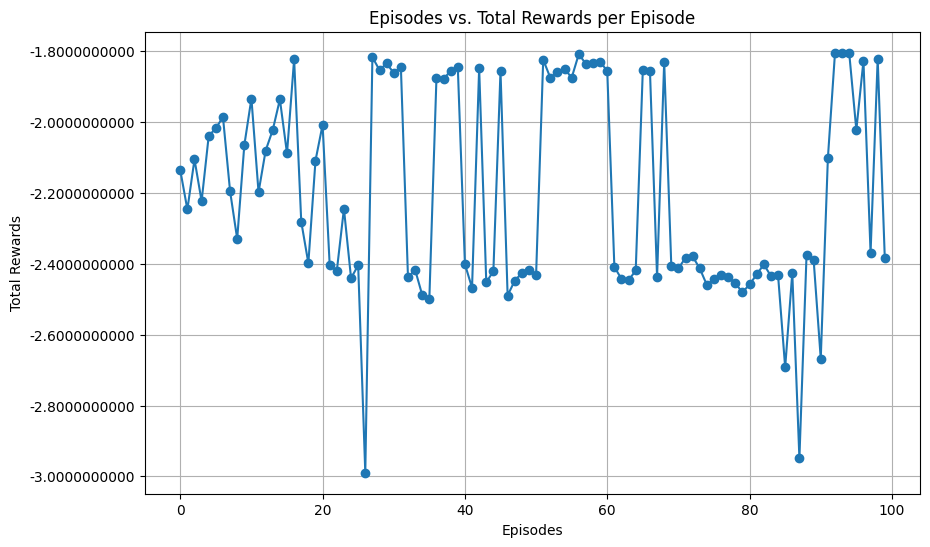

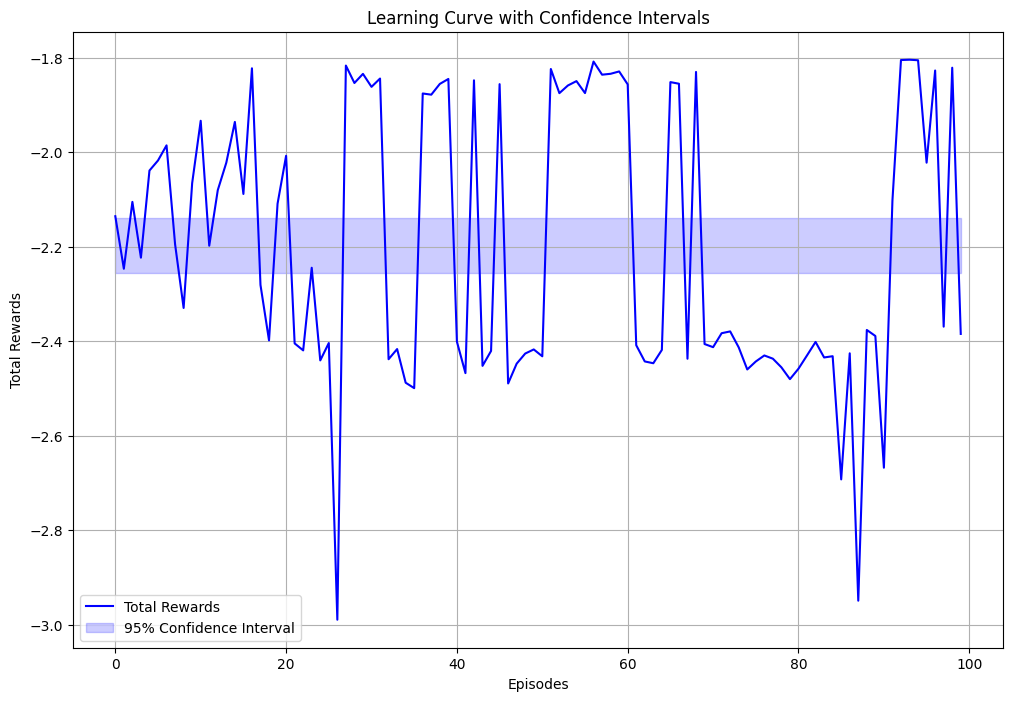

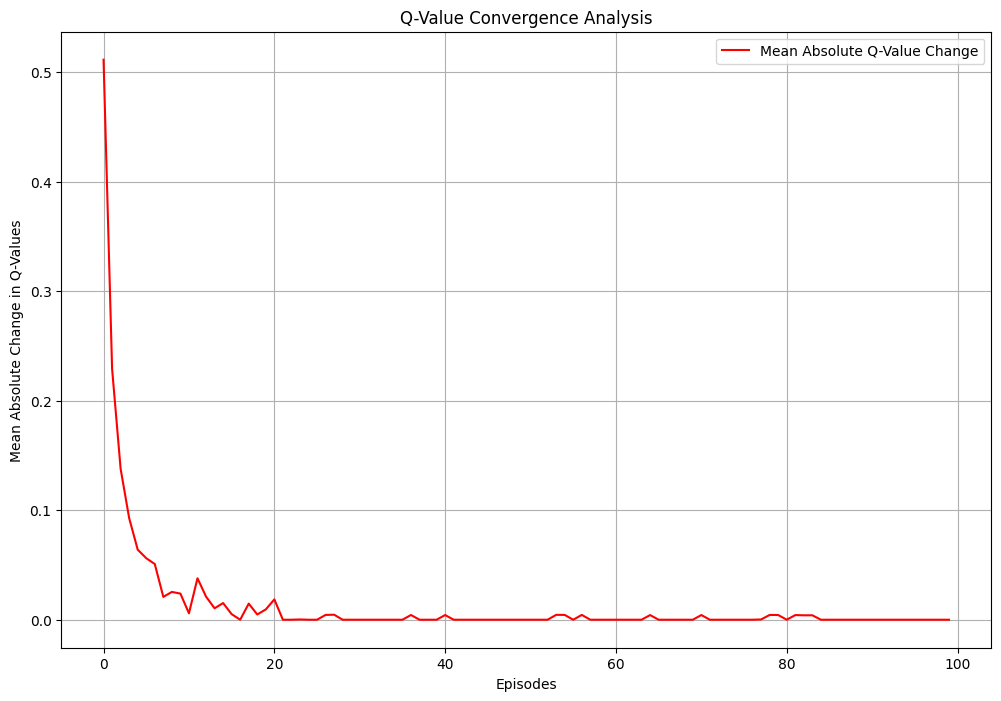

In [ ]:
import numpy as np
import subprocess
import pickle
import os
from collections import deque
import random
import matplotlib.pyplot as plt
from google.colab import files
import scipy.stats as stats
import seaborn as sns
import shap

class CompilerEnv:
    def __init__(self, code_path):
        self.code_path = code_path
        self.flags = compatible_flags
        self.state_space = len(self.flags)
        self.action_space = len(self.flags)
        self.current_state = tuple([0] * self.state_space)

    def reset(self):
        self.current_state = tuple([0] * self.state_space)
        return self.current_state

    def compile_and_measure(self, flags):
        flags_str = ' '.join([self.flags[i] for i, flag in enumerate(flags) if flag])
        compile_command = f"gcc {self.code_path} {flags_str} -lm  -o output"
        run_command = "./output"

        try:
            compile_result = subprocess.run(compile_command, shell=True, capture_output=True, text=True, timeout=10)
            if compile_result.returncode != 0:
                print("Compilation failed:", compile_result.stderr)
                return float('inf')

            subprocess.run(f"chmod +x output", shell=True)

            run_result = subprocess.run(run_command, shell=True, capture_output=True, text=True, timeout=10)
            if run_result.returncode != 0:
                print("Execution failed:", run_result.stderr)
                return float('inf')

            output_lines = run_result.stdout.strip().split('\n')
            execution_time = float(output_lines[-1])
            return execution_time

        except subprocess.TimeoutExpired:
            print("Execution timed out")
            return float('inf')

    def step(self, action):
        current_flags = list(self.current_state)
        current_flags[action] = 1 - current_flags[action]
        self.current_state = tuple(current_flags)

        execution_time = self.compile_and_measure(self.current_state)
        reward = -execution_time

        return self.current_state, reward, False

    def render(self):
        print(f"State: {self.current_state}")

class QLearningAgent:
    def __init__(self, state_space, action_space, learning_rate=0.1, discount_factor=0.9, exploration_rate=1.0,
                 exploration_decay=0.99, q_table_file='q_table_deque.pkl', memory_size=100, batch_size=16):
        self.state_space = state_space
        self.action_space = action_space
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = exploration_rate
        self.epsilon_decay = exploration_decay
        self.q_table_file = q_table_file
        self.q_table = self.load_q_table()
        self.memory = deque(maxlen=memory_size)
        self.batch_size = batch_size

    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            state_actions = self.q_table.get(state, np.zeros(self.action_space))
            action = np.argmax(state_actions)
        return action

    def learn(self, state, action, reward, next_state):
        if state not in self.q_table:
            self.q_table[state] = np.ones(self.action_space)
        if next_state not in self.q_table:
            self.q_table[next_state] = np.zeros(self.action_space)

        predict = self.q_table[state][action]
        target = reward + self.gamma * np.max(self.q_table[next_state])
        self.q_table[state][action] += self.lr * (target - predict)
        self.epsilon *= self.epsilon_decay

    def remember(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state in batch:
            self.learn(state, action, reward, next_state)

    def save_q_table(self):
        with open(self.q_table_file, 'wb') as f:
            pickle.dump(self.q_table, f)
        files.download(self.q_table_file)
        print("Q-table saved.")

    def load_q_table(self):
        if os.path.exists(self.q_table_file):
            with open(self.q_table_file, 'rb') as f:
                print("Q-table loaded.")
                return pickle.load(f)
        else:
            return {}

def train(agent, env, episodes=100):
    rewards = []  # List to store total rewards per episode
    q_value_changes = []  # List to store Q-value changes
    policies = []  # To store policies at various checkpoints
    checkpoints = [0, 25, 50, 75, 100]

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        episode_rewards = []  # List to store rewards of each step in the episode
        episode_states = []  # List to store states of each step in the episode

        previous_q_table = agent.q_table.copy()  # Copy the Q-table at the start of the episode

        for step in range(100):
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            agent.remember(state, action, reward, next_state)
            state = next_state
            total_reward += reward
            episode_rewards.append(reward)
            episode_states.append(state)

            if done:
                break

        agent.replay()
        rewards.append(total_reward)  # Append the total reward for this episode

        # Ensure that previous_q_table has all the states of the current q_table
        for state in agent.q_table:
            if state not in previous_q_table:
                previous_q_table[state] = np.zeros(agent.action_space)

        # Calculate Q-value changes for convergence analysis
        q_value_change = np.mean([np.abs(agent.q_table[state][action] - previous_q_table[state][action])
                                  for state in agent.q_table
                                  for action in range(agent.action_space)])
        q_value_changes.append(q_value_change)

        # Save policies at checkpoints
        if episode in checkpoints:
            policy = {state: np.argmax(agent.q_table[state]) for state in agent.q_table}
            policies.append(policy)

        # Print Episode Summary
        print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}")

    agent.save_q_table()


    # Plotting the graph with six decimal places
    plt.figure(figsize=(10, 6))
    plt.plot(range(episodes), rewards, marker='o', linestyle='-')
    plt.xlabel('Episodes')
    plt.ylabel('Total Rewards')
    plt.title('Episodes vs. Total Rewards per Episode')

    # Set y-ticks to show 6 decimal places
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.10f}'))

    plt.grid(True)
    plt.show()


    # Learning Curve with Confidence Intervals
    means = np.mean(rewards)
    sems = stats.sem(rewards)
    conf_interval = stats.t.interval(0.95, len(rewards)-1, loc=means, scale=sems)

    plt.figure(figsize=(12, 8))
    plt.plot(range(episodes), rewards, label='Total Rewards', color='blue')
    plt.fill_between(range(episodes), conf_interval[0], conf_interval[1], color='blue', alpha=0.2, label='95% Confidence Interval')
    plt.xlabel('Episodes')
    plt.ylabel('Total Rewards')
    plt.title('Learning Curve with Confidence Intervals')
    plt.legend()
    plt.grid(True)
    plt.show()


    # Q-Value Convergence Analysis
    plt.figure(figsize=(12, 8))
    plt.plot(range(episodes), q_value_changes, label='Mean Absolute Q-Value Change', color='red')
    plt.xlabel('Episodes')
    plt.ylabel('Mean Absolute Change in Q-Values')
    plt.title('Q-Value Convergence Analysis')
    plt.legend()
    plt.grid(True)
    plt.show()




    # Feature Importance Analysis (if applicable)
    # Assuming 'state_features' is a NumPy array or DataFrame containing the features of each state
    # If your states are not feature-based, skip this part
    # explainer = shap.Explainer(agent.q_table, state_features)
    # shap_values = explainer(state_features)
    # shap.summary_plot(shap_values, state_features)
def evaluate(agent, env, episodes=10):
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0

        for step in range(100):
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            state = next_state
            total_reward += reward

            if done:
                break

        print(f"Episode {episode + 1}/{episodes},  Reward per episode : {total_reward}")

# Example usage:
code_file= 'MI_bench_qsort.c'
flags =  ['-O0', '-O1', '-O2', '-O3', '-Os', '-Ofast', '-Og', '-fno-inline']
compatible_flags = flags  # Assuming 'compatible_flags' is the list of flags used

env = CompilerEnv(code_file)
agent = QLearningAgent(env.state_space, env.action_space)

train(agent, env)
